![image.png](./img/cabecera_rl.png)

# El lago congelado

## Contenidos

* [Imports iniciales y funciones de animacion](#Imports-iniciales-y-funciones-de-animacion)  

* [Aplicando Q-Learning](#Aplicando-Q-Learning)  

* [Evaluacion](#Evaluacion)  

* [EXTRA: Terrenos resbaladizos](#EXTRA:-Terrenos-resbaladizos)  



En el siguiente ejercicio vamos a intentar ayudar a un simpático muchacho a poder alcanzar un regalo navideño atravesando un lago helado con algún que otro punto peligroso donde el hielo están fino que de pisarlo se hundiría congelándose.

En concreto, queremos que nuestro agente aprenda a cruzar el lago hasta el regalo en el escenario de la imagen:

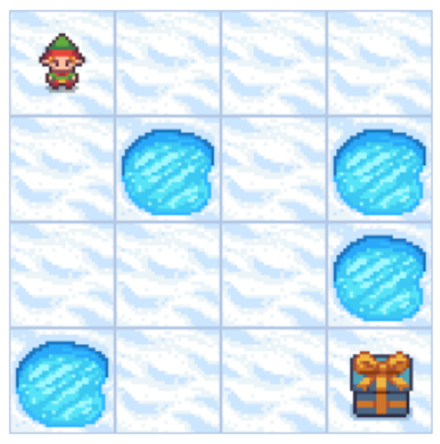

Para ello, vamos a utlizar uno de los entornos contenidos en el GYM de OpenAI que hemos aprendido a utilizar en las sesiones anteriores. Además emplearemos las funciones de animación de Matplotlib para poder evaluar visualmente el éxito o fracaso de nuestro aprendizaje por refuerzo.

### Imports iniciales y funciones de animacion  

[al indice](#Contenidos)  



Como ayuda inicial, incluimos aquí los imports y las funciones básicas para hacer las animaciones, salvo una pequeña función que se pide implementar...

In [5]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [6]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

Codifica ahora una función de nombre plot_environment que reciba un entorno como parámetro y pinte utilizando el metodo imshow del módulo pyplot, que hemos cargado anteriormente, para pintar el estado actual del entorno (tendrás que hacer uso del método render del entorno)

In [12]:
def plot_environment(env):
    frame = env.render()
    plt.figure()
    plt.imshow(frame)
    plt.show()

Importa el módulo gym e instancia en una variable el entorno "FrozenLake-v1". Utiliza también los parámetros, is_slippery = False y render_mode = "rgb_array". Recuerda terminar la llamada a la función make con ".env" para saltarnos la limitación de duración de un episodio.

In [2]:
import gym
env = gym.make("FrozenLake-v1", is_slippery = False, render_mode = "rgb_array").env


Reinicia el entorno, pinta el estado inicial así como el tamaño del espacio de acciones y el espacio de estados

4 16


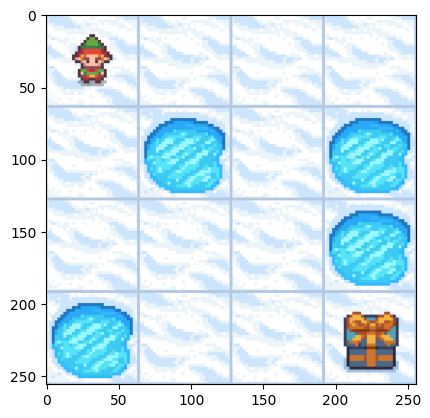

In [7]:
env.reset()
print(env.action_space.n, env.observation_space.n)
plot_environment(env)


La lista de acciones es:  
0: Mover a la izquierda

1: Mover hacia abajo

2: Mover a la derecha

3: Mover hacia arriba

Compruébalo ejecutando la siguiente serie de movimientos (si hace falta resetea el entorno antes): [2,2,1,0,3].
Hazlo primero paso a paso utilizando la función plot_environment

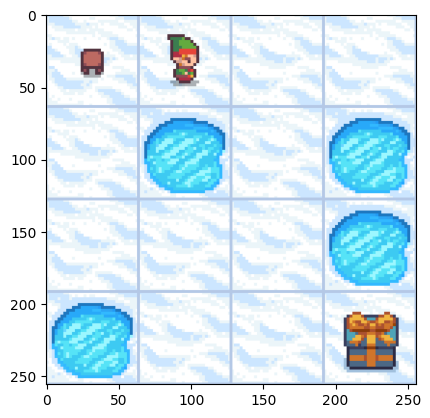

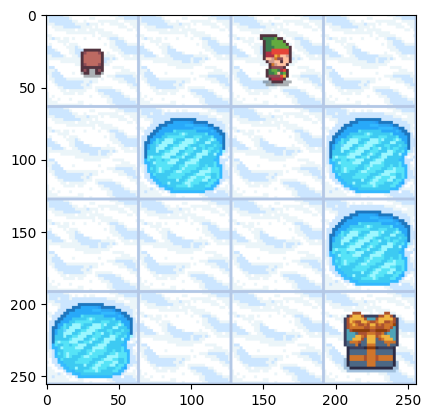

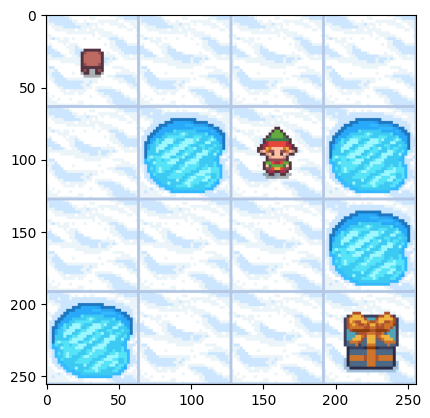

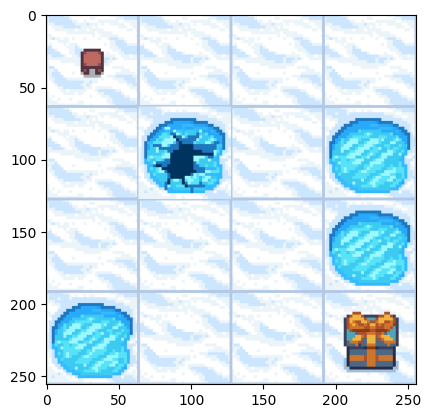

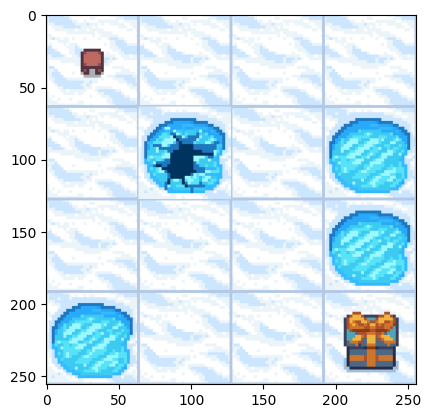

In [14]:
env.reset()
camino_malo = [2,2,1,0,3]
frames = []
for i in camino_malo:
    env.step(i)
    plot_environment(env)
    frames.append(env.render())

Y ahora a partir de la función plot_animation, recuerda que lo que se le pasa a esta función es un conjunto ordenado de imagenes (la que proporciona el método render al invocarlo env.render), tal como hicimos en el ejemplo del vagón y la montaña

In [15]:
plot_animation(frames)

### Aplicando Q-Learning  

[al indice](#Contenidos)  



Crea una estructura para la tabla Q (q-table)

In [17]:
import numpy as np

q_table = np.zeros([env.observation_space.n, env.action_space.n])

q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Lo siguiente es seleccionar los valores de los hiperparámetros: la tasa de aprendizaje (alpha), el factor de descuento (gamma) y el factor epsilon, ya que implementaremos un epsilon-greedy como el que hemos visto en las sesiones anteriores.

Prueba con los siguientes:  
alpha = 0.8  
gamma = 0.95  
epsilon = 0.1  

In [21]:
alpha = 0.8
gamma = 0.95
epsilon = 0.3

Ahora es el momento de implementar la estimación de la tabla Q. Utilizando un algoritmo similar al empleado con el SmartCab construye la tabla Q.

Empieza con un número de episodios menor (prueba entre 2500 y 5000), construye la tabla Q y mira a ver su contenido. Seguramente no te convenza, así que te invito a que subar el epislon a 0.2 e incluso a 0.3 hasta que la tabla Q tenga una apariencia relativamente interesante. Tambien puedes ver el resultado haciendo el apartado siguiente y luego probar con los otros valores de epsilon. ¿Por qué crees que sucede esto?

Aunque no es necesario, puedes llevar un recuento de los episodios fallidos (nuestro querido agente cae al agua al pisar uno de los hoyos). Para ello ten en cuenta que el esquema de recompensas de este entorno es:
- Por llegar al regalo, 1 punto
- En cualquier otra situación, 0 puntos


In [29]:
import random
from IPython.display import clear_output
num_episodes = 5000
env.reset()
state = env.s
q_table = np.zeros([env.observation_space.n, env.action_space.n])

for i in range(1, num_episodes + 1):
    epochs, reward = 0,0
    done = False
    epsilon = 0.9/max(num_episodes//1000,1)
    #print(epsilon)
    while not done:
        if random.uniform(0,1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
        next_state, reward, done, truncated, info = env.step(action)
        #reward = 1 if reward == 0 else 100000
        next_max = np.max(q_table[next_state]) # maxQ(s',a')
        old_value = q_table[state,action]
        new_value = (1 - alpha) * old_value + alpha * \
        (reward + gamma * next_max)
        
        q_table[state,action] = new_value
        
        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait = True)
        print(f"Episode: {i}, {i/num_episodes * 100:.2f}")
        #plot_environmnet(env)

    state,info = env.reset()
        
print("Entrenamiento finalizado")

Episode: 5000, 100.00
Entrenamiento finalizado


Muestra la tabla-Q

In [30]:
q_table

array([[0.73509189, 0.77378094, 0.6983373 , 0.73509189],
       [0.73509189, 0.        , 0.        , 0.67036805],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.81450625, 0.        ],
       [0.857375  , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.81450616],
       [0.        , 0.        , 0.        , 0.        ]])

### Evaluacion  

[al indice](#Contenidos)  



Ahora que tenemos nuestra tabla-Q estimada es hora de ver si realmente hemos tenido éxito con nuestro aprendizaje. "Juega" un episodio aplicando solo "explotation" (es decir escoge siempre la accion que de lugar al máximo Q) y visualizalo utilizando plot_animation.  
OJO: 
Acuerdate de reinicializar el entorno y de guardar el env.render del estado inicial como primera imagen a pasar a plot_animation

In [31]:
state, info = env.reset()

frames = [env.render()]
done = False
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, truncated, info = env.step(action)
    frames.append(env.render())
print(len(frames))
plot_animation(frames)

7


¿Qué tal ha ido? 

### EXTRA: Terrenos resbaladizos  

[al indice](#Contenidos)  



Como ejercicio adicional, repite el anterior pero esta vez creando utilizando la siguiente invocación del entorno

In [34]:
env = gym.make("FrozenLake-v1", render_mode = "rgb_array", is_slippery = True).env

Al activar el modo "resbaladizo" (slippery), ahora las acciones no siempre tienen el efecto esperado, de hecho sólo una de cada tres veces intentar ir en una dirección nos llevará en esa dirección debido a lo resbaladizo del terreno.

Repite el código de entrenamiento, con los hiperparametros de antes, salvo epislon (escoge en este caso el que mejor te haya ido) y recuerda inicializar la tabla-Q!!! con ceros (créala de nuevo).

In [35]:
import random
from IPython.display import clear_output
num_episodes = 5000
env.reset()
state = env.s
q_table = np.zeros([env.observation_space.n, env.action_space.n])
epsilon = 0.3
for i in range(1, num_episodes + 1):
    epochs, reward = 0,0
    done = False
    
    #print(epsilon)
    while not done:
        if random.uniform(0,1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
        next_state, reward, done, truncated, info = env.step(action)
        #reward = 1 if reward == 0 else 100000
        next_max = np.max(q_table[next_state]) # maxQ(s',a')
        old_value = q_table[state,action]
        new_value = (1 - alpha) * old_value + alpha * \
        (reward + gamma * next_max)
        
        q_table[state,action] = new_value
        
        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait = True)
        print(f"Episode: {i}, {i/num_episodes * 100:.2f}")
        #plot_environmnet(env)

    state,info = env.reset()
        
print("Entrenamiento finalizado")

Episode: 5000, 100.00
Entrenamiento finalizado


Muestra la nueva tabla de valores Q y compárala con la del entorno sin hielo resbaladizo

In [36]:
q_table

array([[0.29685887, 0.23921746, 0.30727791, 0.30694851],
       [0.01614231, 0.27178832, 0.06040988, 0.18992598],
       [0.14110568, 0.19568495, 0.1480467 , 0.14792249],
       [0.02592941, 0.02912177, 0.00604118, 0.15361801],
       [0.27860282, 0.04660971, 0.23411527, 0.01105484],
       [0.        , 0.        , 0.        , 0.        ],
       [0.12820902, 0.00550091, 0.02312788, 0.02759738],
       [0.        , 0.        , 0.        , 0.        ],
       [0.00240809, 0.01570764, 0.01285795, 0.33712317],
       [0.09264577, 0.38085136, 0.00415247, 0.08261218],
       [0.87035388, 0.0072357 , 0.07790338, 0.07293007],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.14619833, 0.12204414, 0.73292986, 0.09235817],
       [0.54943807, 0.5885494 , 0.97160924, 0.69225577],
       [0.        , 0.        , 0.        , 0.        ]])

Ahora, como en el escenario anterior, escribe el código (puedes emplear el mismo que hiciste antes) para ejecutar un único episodio en el que la acción se escoja a partir de los valores de la tabla-Q. Al finalizar utiliza plot_animation para mostrar el episodio. De nuevo, recuerda reinicializar el entorno al principio y añadir como primer "frame" el resultado de env.render() tras la reinicialización.

In [49]:
state, info = env.reset()

frames = [env.render()]

done = False
intentos = 0
reward = 0
while reward == 0:
    intentos += 1
    env.reset()
    frames = [env.render()]
    done = False
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
print(len(frames))
print(f"He nesesitao {intentos} intentos")
plot_animation(frames)


21
He nesesitao 4 intentos


Ejecuta el episodio varias veces, hasta que ocurra algo inesperado... ¿Qué pasado? ¿Cómo lo explicas? (Lo veremos en la clase en vivo) Si no ocurre algo "positivo", prueba a subir los steps de entrenamiento de la tabla q "resbaladiza".